# TensorFlow Tutorial #23
# Time-Series Prediction

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

## 1. Read in data, either combined or single country

In [5]:
df=pd.read_csv("output/2ModerateLockdown/full.csv",header=[0,1])
df['Switzer'].head()

,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,driving,transit,walking
0,128,46,1,1,7.470,2.685,0.058,0.058,105.36,119.53,167.19
1,188,60,1,0,10.972,3.502,0.058,0.000,91.72,101.40,103.37
2,265,77,3,2,15.466,4.494,0.175,0.117,97.44,98.01,97.60
3,321,56,3,0,18.734,3.268,0.175,0.000,94.05,94.36,92.04
4,382,61,4,1,22.294,3.560,0.233,0.058,92.55,90.51,99.58


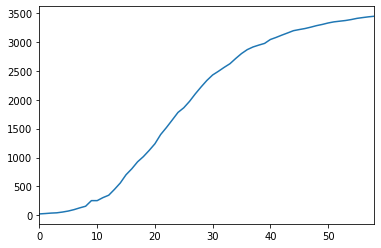

In [582]:
df['Switzerland']['total_cases_per_million'].plot();

In [7]:
df.values.shape

(59, 78)

## 2. Select country and index that we would like to predict

In [640]:
target_country = 'Germany'
target_names = ['new_cases']
df_targets = df[target_country][target_names]
df_targets.tail()

,new_cases
54,2337
55,2055
56,1737
57,1018
58,1144


In [641]:
x_data = df.values[0:]
y_data = df_targets.values[0:]
print("Shape:", x_data.shape)
print("Shape:", y_data.shape)

Shape: (59, 78)
Shape: (59, 1)


## 3. Construct training and testing dataset

In [642]:
num_data = len(x_data)
train_split = 0.85
num_train = int(train_split * num_data)
num_test = num_data - num_train
print(num_train,num_test)


50 9


In [643]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
num_x_signals = x_data.shape[1]
num_y_signals = y_data.shape[1]
print(num_x_signals,num_y_signals)

78 1


## 4. Concert the data to [-1,1]
### The neural network works best on values roughly between -1 and 1, so we need to scale the data before it is being input to the neural network. We can use scikit-learn for this.

In [644]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: 0.0
Max: 139897.0


In [645]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0000000000000002


In [646]:
x_test_scaled = x_scaler.transform(x_test)
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(50, 78)
(50, 1)


## 5. batch generator 

In [647]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [648]:
batch_size = 10
sequence_length = 7
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)
x_batch, y_batch = next(generator)
print(x_batch.shape)
print(y_batch.shape)

(10, 7, 78)
(10, 7, 1)


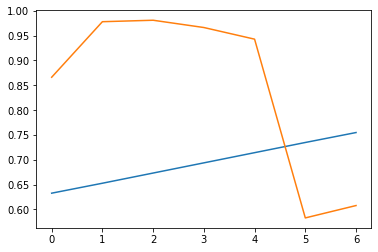

In [649]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [650]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

## 6. Constructing model

In [651]:
model = Sequential()
model.add(GRU(units=64,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))
model.add(Dense(num_y_signals, activation='linear'))

In [652]:
warmup_steps = 3
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [653]:
optimizer = RMSprop(lr=1e-3)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)
model.summary()

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_38 (GRU)                 (None, None, 64)          27648     
_________________________________________________________________
dense_56 (Dense)             (None, None, 1)           65        
Total params: 27,713
Trainable params: 27,713
Non-trainable params: 0
_________________________________________________________________


In [654]:
path_checkpoint = '30checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [655]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)
callback_tensorboard = TensorBoard(log_dir='./30_logs/',
                                   histogram_freq=0,
                                   write_graph=False)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]


## 7. Training

In [656]:
%%time
model.fit(x=generator,
          epochs=20,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

Train for 100 steps, validate on 1 samples
Epoch 1/20
 96/100 [===========================>..] - ETA: 0s - loss: 0.0410
Epoch 00001: val_loss improved from inf to 0.06771, saving model to 30checkpoint.keras
100/100 [==============================] - 6s 55ms/step - loss: 0.0395 - val_loss: 0.0677
Epoch 2/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0156
Epoch 00002: val_loss did not improve from 0.06771

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 2s 15ms/step - loss: 0.0155 - val_loss: 0.1116
Epoch 3/20
 97/100 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 00003: val_loss improved from 0.06771 to 0.03999, saving model to 30checkpoint.keras
100/100 [==============================] - 2s 16ms/step - loss: 0.0013 - val_loss: 0.0400
Epoch 4/20
 98/100 [============================>.] - ETA: 0s - loss: 7.7048e-04
Epoch 00004: val_loss improved from 0.03999 to 0.03930, saving m

In [657]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

1/1 [==============================] - 0s 7ms/sample - loss: 0.0350


## 8. Comparison and plot

Forecast Accuracy of: new_cases
mape   :  2.8079
mae    :  905.2761
mpe    :  -1.4851
rmse   :  1004.4068


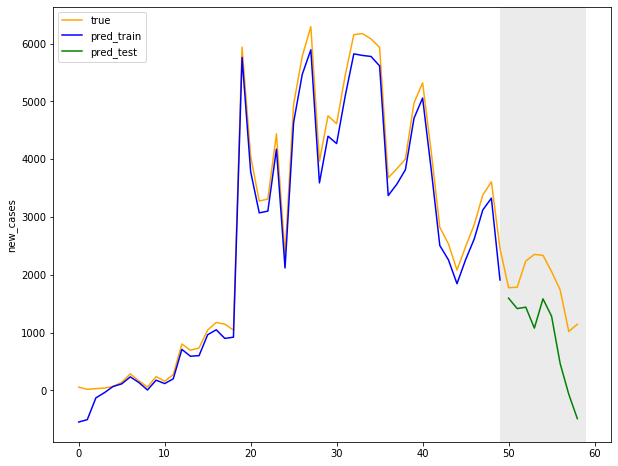

In [658]:
def plot_comparison(start_idx, length=100):
    def adjust(val, length= 6): return str(val).ljust(length)
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    x1 = x_train_scaled
    y_true1 = y_train
    x2 = x_test_scaled
    y_true2 = y_test
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Input-signals for the model.
    x1 = np.expand_dims(x1, axis=0)
    x2 = np.expand_dims(x2, axis=0)

    # Use the model to predict the output-signals.
    y_pred1 = model.predict(x1)
    y_pred2 = model.predict(x2)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled1 = y_scaler.inverse_transform(y_pred1[0])
    y_pred_rescaled2 = y_scaler.inverse_transform(y_pred2[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred1 = y_pred_rescaled1[:, signal]
        signal_pred2 = y_pred_rescaled2[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true1 = y_true1[:, signal]
        signal_true2 = y_true2[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(10,8))
        #print(type(signal_true1))
        signal_true=np.append(signal_true1,signal_true2)
        #print(signal_true1)
        x = np.arange(len(signal_true1),len(signal_true1)+len(signal_true2),1)  
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true',color="orange")
        plt.plot(signal_pred1, label='pred_train',color="blue")
        #plt.plot(x,signal_true2, label='true_test',color="orange")
        signal_2=[732, 647,506,439,471,488,398,298,200]
        signal_3=[828.29469027, 755.19547283, 562.71102491, 502.12047018, 436.77218798,544.44769629, 532.20588431, 522.5428247,  417.29499168]
        plt.plot(x,signal_pred2, label='pred_test',color='green')

        # Plot grey box for warmup-period.
        p = plt.axvspan(49, 59, facecolor='black', alpha=0.08)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        print('Forecast Accuracy of: new_cases')
        accuracy_prod = forecast_accuracy(signal_true2, signal_pred2)
        for k, v in accuracy_prod.items():
            print(adjust(k), ': ', round(v,4))
        #plt.show()
        plt.savefig('Germany.png', bbox_inches="tight")
plot_comparison(0, length=100)

In [343]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    #me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    #corr = np.corrcoef(forecast, actual)[0,1]   # corr
    #mins = np.amin(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     #maxs = np.amax(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
    #minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'mae': mae,
            'mpe': mpe, 'rmse':rmse})

#     return({'mape':mape, 'me':me, 'mae': mae, 
#             'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})



# print('\nForecast Accuracy of: driving')
# accuracy_prod = forecast_accuracy(df_results['driving_forecast'].values, df_test['driving'])
# for k, v in accuracy_prod.items():
#     print(adjust(k), ': ', round(v,4))

# print('\nForecast Accuracy of: transit')
# accuracy_prod = forecast_accuracy(df_results['transit_forecast'].values, df_test['transit'])
# for k, v in accuracy_prod.items():
#     print(adjust(k), ': ', round(v,4))

# print('\nForecast Accuracy of: walking')
# accuracy_prod = forecast_accuracy(df_results['walking_forecast'].values, df_test['walking'])
# for k, v in accuracy_prod.items():
#     print(adjust(k), ': ', round(v,4))



Forecast Accuracy of: new_cases


NameError: name 'signal_true2' is not defined